#### Master 2 Data Science, UIE

#### `GROUPE:` MAIGA Amadou Djibrila -- KONE Seydou Nanouroukou

---

<div style="font-size: 32px; letter-spacing: 1px; background-color:rgb(37, 49, 175); color: #FFFFFF; border-radius: 5px; padding: 5px 16px; font-weight: bold;">
    Partie I : Prédiction multivariée de données météo (Delhi)
</div>

<div style="font-size: 24px; letter-spacing: 1px; background-color:rgb(100, 110, 210); color: #FFFFFF; border-radius: 5px; padding: 5px 16px; font-weight: bold;">
    0. Importation du dataset
</div>

In [1]:
# Proposition de l'IA Generative pour l'utilisation de PyTorch. Sans ce code, PyTorch fonctionnait pas.

# Ce code définit des variables d'environnement pour contrôler le comportement de TensorFlow et optimiser ses performances.
import os
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU, Bidirectional
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [3]:
path = './DailyDelhiClimate/'
df = pd.read_csv(path + 'DailyDelhiClimateTrain.csv', parse_dates=['date'], index_col='date')

In [4]:
df

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000
...,...,...,...,...
2016-12-28,17.217391,68.043478,3.547826,1015.565217
2016-12-29,15.238095,87.857143,6.000000,1016.904762
2016-12-30,14.095238,89.666667,6.266667,1017.904762


Des valeurs aberante se trouves dans le dataset.

In [5]:
def remove_aberant(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_filtered = df.mask((df < lower_bound) | (df > upper_bound))
    df_cleaned = df_filtered.fillna(df.median())

    return df_cleaned

df = remove_aberant(df)

<div style="font-size: 24px; letter-spacing: 1px; background-color:rgb(100, 110, 210); color: #FFFFFF; border-radius: 5px; padding: 5px 16px; font-weight: bold;">
    1. Séparez les données climatiques en données d'entrainement et test
</div>

In [6]:
train, test = train_test_split(df, test_size=0.3, shuffle=False)

print(f"Les dimension des données d'entrainement : {train.shape}")
print(f"Les dimension des données de test : {test.shape}")

Les dimension des données d'entrainement : (1023, 4)
Les dimension des données de test : (439, 4)


En plus du split nous allons standariser nos donnees

In [7]:
from sklearn.preprocessing import MinMaxScaler

scaler_object = MinMaxScaler()
scaler = scaler_object.fit(train)

train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)

<div style="font-size: 24px; letter-spacing: 1px; background-color:rgb(100, 110, 210); color: #FFFFFF; border-radius: 5px; padding: 5px 16px; font-weight: bold;">
    2. Créez une fonction create_Xseq_and_y et appliquons la
</div>

In [8]:
def create_Xseq_and_y(data, look_back = 20):
    X, y = [], []
    for i in range(len(data) - look_back):
        v = i+look_back
        X.append(data[i:v])
        y.append(data[v])
    return np.array(X), np.array(y)

In [9]:
X_train, y_train = create_Xseq_and_y(train_scaled)
X_test, y_test = create_Xseq_and_y(test_scaled)

print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_test.shape)

X_train.shape:  (1003, 20, 4)
y_train.shape:  (1003, 4)
X_test.shape:  (419, 20, 4)
y_test.shape:  (419, 4)


<div style="font-size: 24px; letter-spacing: 1px; background-color:rgb(100, 110, 210); color: #FFFFFF; border-radius: 5px; padding: 5px 16px; font-weight: bold;">
    3. Choisissez, en justifiant votre choix, un modèle de type RNN parmi le RNN classique, le LSTM, le GRU et le BiLSTM
</div>

Notre choix se portera soit sur le `LSTM` soit sur le `GRU`. En effet nos donnees meteo sont des donnees assez simple a notre avis, et donc pas besoin de selectionner un modele complique comme le `BiLSTM`. <br><br>

Si un choix doit etre fait absolument, le notre serait le `GRU` pour sa simplicité. Mais nous allons un plus pousser la comparaison dans les prochaine questions.

In [10]:
# LSTM model
def create_lstm(units):
    model = Sequential()
    # Input layer
    model.add(LSTM(units = units, return_sequences = True, input_shape = [X_train.shape [1], X_train.shape[2]]))
    model.add(Dropout(0.2))
    # Hidden layer
    model.add(LSTM(units = units) )
    model.add(Dropout(0.2))
    model.add(Dense(units = 4))
    #Compile model
    model.compile(optimizer='adam', loss='mse')
    model.summary()
    return model

# GRU model
def create_gru(units):
    model = Sequential()
    # Input layer
    model.add(GRU(units = units, return_sequences = True, input_shape = [X_train.shape [1], X_train.shape[2]]))
    model.add(Dropout(0.2))
    # Hidden layer
    model.add(GRU(units = units) )
    model.add(Dropout(0.2))
    model.add(Dense(units = 4))
    #Compile model
    model.compile(optimizer='adam', loss='mse')
    model.summary()
    return model

# BiLSTM model
def create_bilstm(units):
    model = Sequential()
    # Input layer
    model.add(Bidirectional(LSTM(units = units, return_sequences = True), input_shape = [X_train.shape [1], X_train.shape[2]]))
    model.add(Dropout(0.2))
    # Hidden layer
    model.add(Bidirectional(LSTM(units = units)))
    model.add(Dropout(0.2))
    model.add(Dense(units = 4))
    #Compile model
    model.compile(optimizer='adam', loss='mse')
    model.summary()
    return model

In [11]:
model_gru = create_gru(64)
model_lstm = create_lstm(64)
model_bilstm = create_bilstm(64)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 20, 64)         │        13,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 64)             │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,660 (151.02 KB)

 Trainable params: 38,660 (151.02 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 20, 64)         │        17,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,948 (199.02 KB)

 Trainable params: 50,948 (199.02 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 20, 128)        │        35,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 20, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,660 (526.02 KB)

 Trainable params: 134,660 (526.02 KB)

 Non-trainable params: 0 (0.00 B)

<div style="font-size: 24px; letter-spacing: 1px; background-color:rgb(100, 110, 210); color: #FFFFFF; border-radius: 5px; padding: 5px 16px; font-weight: bold;">
    4. Entrainez le modèle mis en place à l’aide des données d’entrainement précédemment préparées et évaluez la qualité de l’entrainement.
</div>

In [12]:
from tensorflow import keras
def fit_model(model):
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10)
    history = model.fit(X_train, y_train, epochs = 100, validation_split = 0.2, batch_size = 16, shuffle = False, callbacks = [early_stop])
    return history

In [13]:
history_gru = fit_model(model_gru)
history_lstm = fit_model(model_lstm)
history_bilstm = fit_model(model_bilstm)

Epoch 1/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.1611 - val_loss: 0.0424
Epoch 2/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0364 - val_loss: 0.0288
Epoch 3/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0271 - val_loss: 0.0200
Epoch 4/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0225 - val_loss: 0.0248
Epoch 5/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0230 - val_loss: 0.0197
Epoch 6/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0226 - val_loss: 0.0321
Epoch 7/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0230 - val_loss: 0.0304
Epoch 8/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0230 - val_loss: 0.0225
Epoch 9/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0229 - val_loss: 0.0202
Epoch 10/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0201 - val_loss: 0.0261
Epoch 11/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0203 - val_loss: 0.0198
Epoch 12/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step

Evaluation

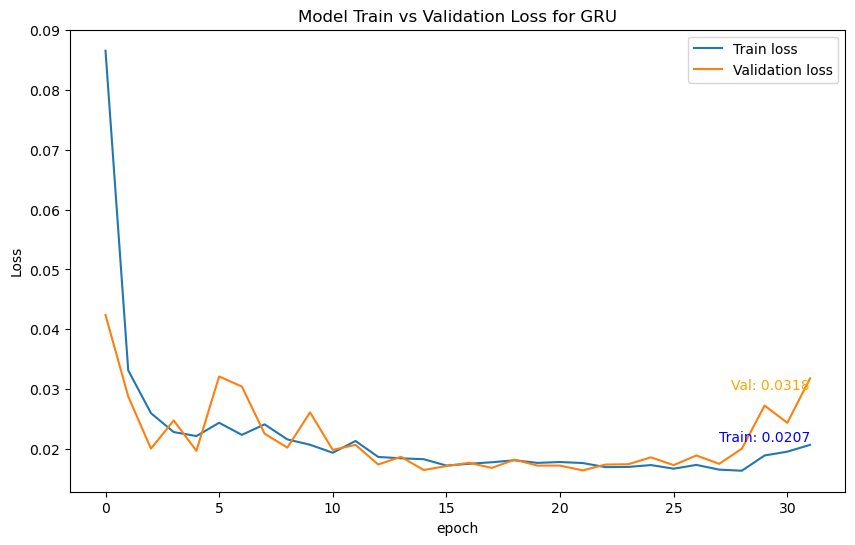

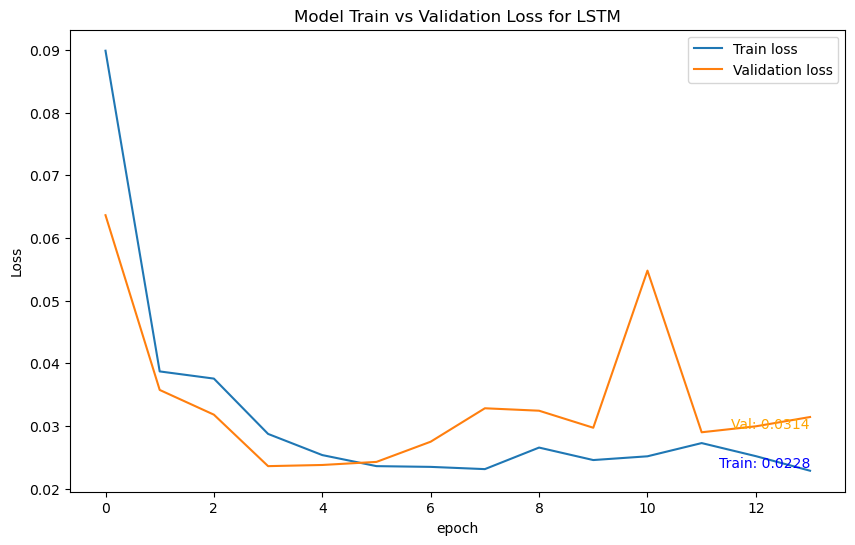

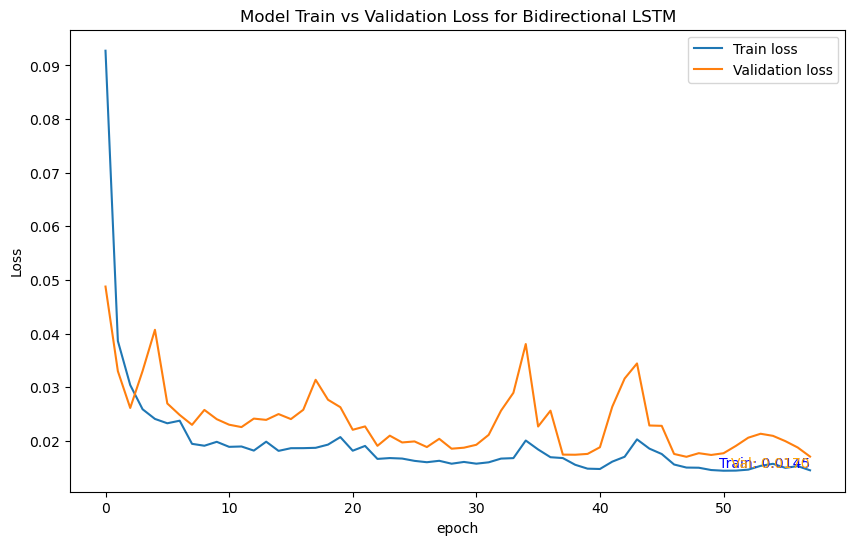

In [14]:
#PS : Pour Annoter la dernière des courbes d'entraînement et de validation -> IA

def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    
    last_train_loss = history.history['loss'][-1]
    last_val_loss = history.history['val_loss'][-1]
    
    # Annoter la dernière valeur de la perte d'entraînement
    plt.text(
        len(history.history['loss']) - 1, 
        last_train_loss,                 
        f'Train: {last_train_loss:.4f}', 
        ha='right', va='bottom',          
        fontsize=10,
        color='blue'
    )
    
    # Annoter la dernière valeur de la perte de validation
    plt.text(
        len(history.history['val_loss']) - 1,  
        last_val_loss,                       
        f'Val: {last_val_loss:.4f}',          
        ha='right', va='top',
        fontsize=10,
        color='orange'
    )
    
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')
    plt.show
    
plot_loss(history_gru, 'GRU')
plot_loss(history_lstm, 'LSTM')
plot_loss(history_bilstm, 'Bidirectional LSTM')    

En therme de performance vis a vis des pertes, les 3 modeles se valent plus ou moins. Mais nous allons rester sur notre choix du `GRU` comme dit precedement.

<div style="font-size: 24px; letter-spacing: 1px; background-color:rgb(100, 110, 210); color: #FFFFFF; border-radius: 5px; padding: 5px 16px; font-weight: bold;">
    5. Prédisez les données de test avec le modèle entrainez
</div>

In [15]:
def prediction(model, X_test):
    predictions_scaled = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions_scaled)
    return predictions

In [16]:
prediction_gru = prediction(model_gru, X_test)

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


In [17]:
prediction_gru

array([[  19.347942 ,   69.25958  ,    2.1253455, 1013.22906  ],
       [  19.864264 ,   68.31381  ,    2.596705 , 1012.5375   ],
       [  19.817198 ,   59.01877  ,    4.0838137, 1012.27057  ],
       ...,
       [  13.93201  ,   75.774864 ,    4.8445277, 1014.6385   ],
       [  13.1566725,   77.85643  ,    5.4173584, 1015.5227   ],
       [  13.296351 ,   77.388596 ,    5.903883 , 1014.9693   ]],
      dtype=float32)

<div style="font-size: 24px; letter-spacing: 1px; background-color:rgb(100, 110, 210); color: #FFFFFF; border-radius: 5px; padding: 5px 16px; font-weight: bold;">
    6. Calculez l’erreur de prédiction et commentez
</div>

In [18]:
# Transform data back to original data space
y_test_inv = scaler.inverse_transform(y_test)
y_train_inv = scaler.inverse_transform(y_train)

In [19]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

metrics = {}
columns = ["meantemp", "humidity", "wind_speed", "meanpressure"]

for i, col in enumerate(columns):
    rmse = np.sqrt(mean_squared_error(y_test_inv[:, i], prediction_gru[:, i]))
    mse = mean_squared_error(y_test_inv[:, i], prediction_gru[:, i])
    mae = mean_absolute_error(y_test_inv[:, i], prediction_gru[:, i])
    r2 = r2_score(y_test_inv[:, i], prediction_gru[:, i])
    
    metrics[col] = {"RMSE": rmse, "MSE": mse, "MAE": mae, "R2": r2}

# Affichage des métriques
for col, values in metrics.items():
    print(f"\n{col}:")
    print(f"  RMSE: {values['RMSE']:.4f}")
    print(f"  MSE: {values['MSE']:.4f}")
    print(f"  MAE: {values['MAE']:.4f}")
    print(f"  R2: {values['R2']:.4f}")



meantemp:
  RMSE: 4.6589
  MSE: 21.7051
  MAE: 4.0635
  R2: 0.6014

humidity:
  RMSE: 12.7002
  MSE: 161.2954
  MAE: 10.4032
  R2: 0.3827

wind_speed:
  RMSE: 3.2683
  MSE: 10.6815
  MAE: 2.5222
  R2: 0.1875

meanpressure:
  RMSE: 4.2898
  MSE: 18.4024
  MAE: 3.6133
  R2: 0.6185


`REMARQUE :` Nous avons remarquer que les metrics changent par entrainement. Donc l'analyse est a prendre avec des pincettes.

- `meantemp`: Nous avons une erreur d'environ `2` pour le `MAE`, ce qui est assez correcte, Cela signifie que nous avons une erreur de plus de `2 unité` pour la prediction de la temeperature. Mais nous avons une `R2 = 0.5 - 0.8` a peu pres, ce qui signifie que le modeles explique a peu pres `50% a 80%` de la variance des températures. <br><br>

- `humidity`: Nous avons une erreur d'environ `6` pour le `MAE` ce qui est passable pour l'humidité car ces valeurs sont assez grandes. Nous avons egalement une `R2 ~ 0.6 - 0.7` assez correcte. Cela signifie que le modeles explique `60% - 70%` de la variance des l'humidite, ce qui comparé a la temperature est meilleur. <br><br>

- `wind_speed`: Nous avons une erreur `MAE ~ 2` ce qui est pas du tout bon pour des valeurs assez basses tel que la vitesse du vent. Dans la meme continuite nous avons un `R2 ~ 0.1 - 0.2` tres faible. Cela signifie que le modeles explique seulement `10% a 20%` de la variance de vitesse, ce qui n'est pas bon. <br><br>

- `meanpressure`: Nous avons ici un `R2 ~ 6` et un `MAE ~ 3` pour le `meanpressure` ce qui assez encourrangeant.<br><br>

`Conclusion:` Notre modele est passable pour la prediction de la temeperature, assez bonne pour l'humidite et la pression, pas tres efficace pour la vitesse du vent.

<div style="font-size: 24px; letter-spacing: 1px; background-color:rgb(100, 110, 210); color: #FFFFFF; border-radius: 5px; padding: 5px 16px; font-weight: bold;">
    7. Graphique pour chaque variable climatique
</div>

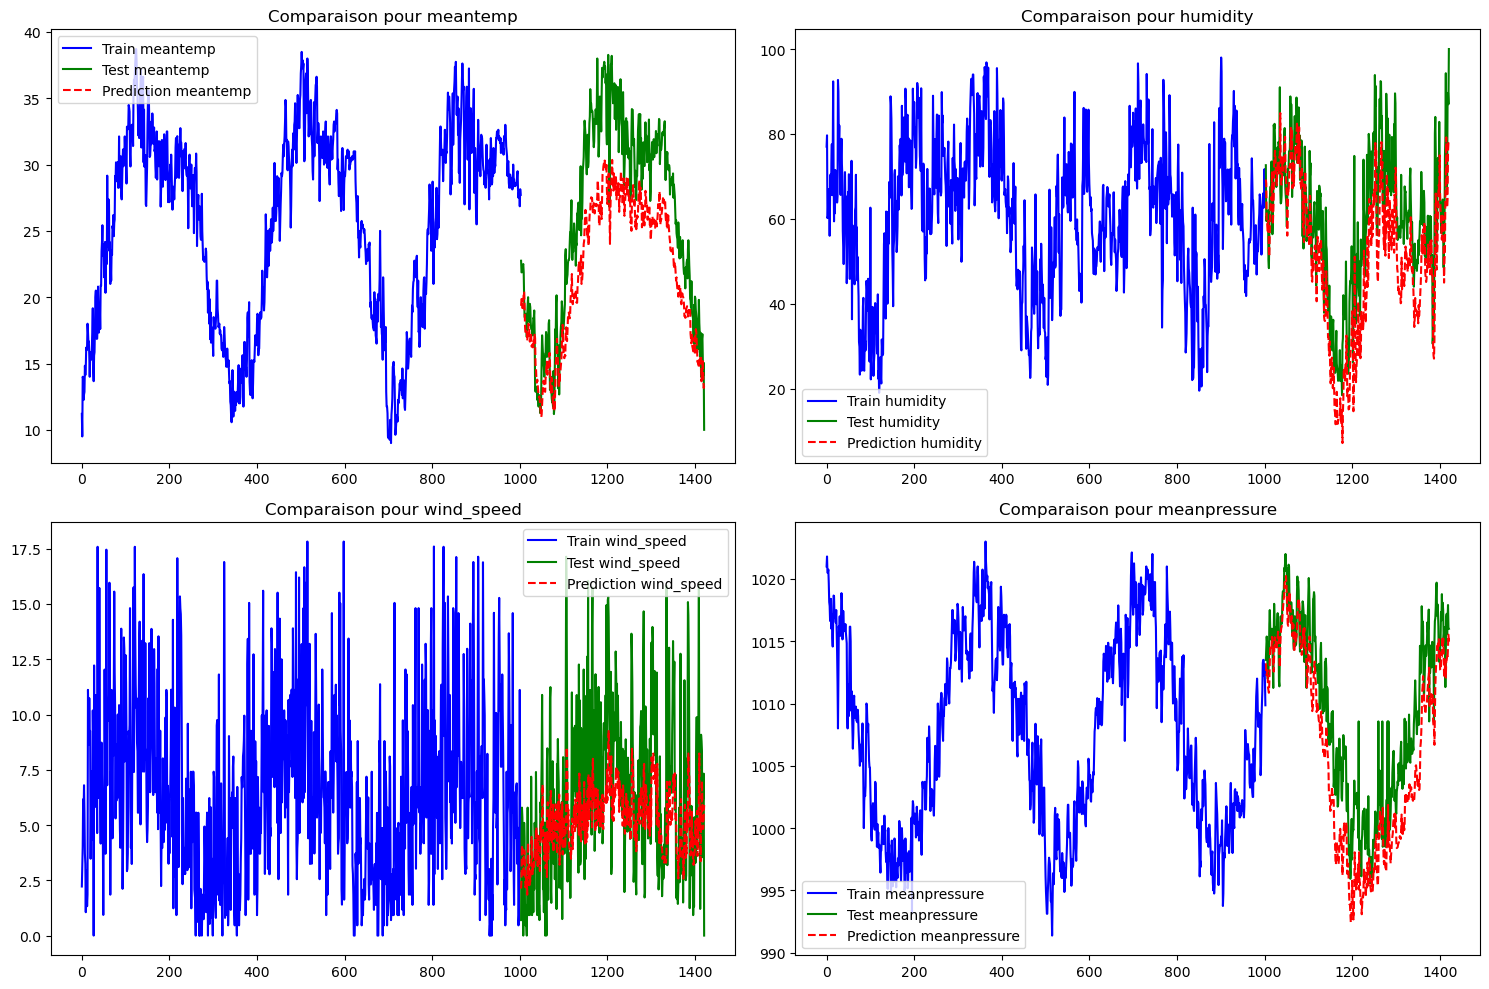

In [20]:
# Aide de l'IA pour le graphe.

variables = ["meantemp", "humidity", "wind_speed", "meanpressure"]
fig, axes = plt.subplots(2, 2, figsize=(15, 10))  # 2 lignes, 2 colonnes

for i, var in enumerate(variables):
    ax = axes[i//2, i%2]  # Position dans la grille
    ax.plot(y_train_inv[:, i], label=f"Train {var}", color="blue")
    ax.plot(range(len(y_train_inv), len(y_train_inv) + len(y_test_inv)), y_test_inv[:, i], label=f"Test {var}", color="green")
    ax.plot(range(len(y_train_inv), len(y_train_inv) + len(y_test_inv)), prediction_gru[:, i], label=f"Prediction {var}", color="red", linestyle="dashed")
    
    ax.set_title(f"Comparaison pour {var}")
    ax.legend()
    
plt.tight_layout()
plt.show()

- `meantemp :` En globalité le modele semble bien predire les valeurs. Ce qui explique pour le `RMSE` était plus élevé que le `MAE`, parce que nous avons quelques erreurs plus importantes. <br><br>

- `humidity :` Comme dit plus haut, le modele semble bien se debrouiller pour la prediction de l'humidite. <br><br>

- `wind_speed :` Nous remarquon que meme si le modeles capture la tendance, elle n'arrive pas a explique la forte variance des valeurs. <br><br>

- `meanpressure :` le modele se debrouille tres bien sur ces prediction de la `pression`<br><br>

<div style="font-size: 16px; letter-spacing: 1px; background-color:rgb(36, 159, 46); color: #FFFFFF; border-radius: 5px; padding: 5px 16px; font-weight: bold;">
    CONCLUSION
</div>
Le modele est bon, sauf pour la vitesse du vent.


<div style="font-size: 24px; letter-spacing: 1px; background-color:rgb(100, 110, 210); color: #FFFFFF; border-radius: 5px; padding: 5px 16px; font-weight: bold;">
    8. Ré-entrainez votre modèle
</div>

In [37]:
model_gru2 = create_gru(64)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_6 (GRU)                     │ (None, 20, 64)         │        13,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_7 (GRU)                     │ (None, 64)             │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,660 (151.02 KB)

 Trainable params: 38,660 (151.02 KB)

 Non-trainable params: 0 (0.00 B)

In [38]:
df_train = pd.read_csv(path + 'DailyDelhiClimateTrain.csv', parse_dates=['date'], index_col='date')
df_test = pd.read_csv(path + 'DailyDelhiClimateTest.csv', parse_dates=['date'], index_col='date')

In [41]:
def pre_processing(df_train, df_test):

    df_train_clean = remove_aberant(df_train)
    df_test_clean = remove_aberant(df_test)

    scaler_object = MinMaxScaler()
    scaler = scaler_object.fit(df_train_clean)
    
    train_scaled = scaler.transform(df_train_clean)
    test_scaled = scaler.transform(df_test_clean)

    X_train, y_train = create_Xseq_and_y(train_scaled)
    X_test, y_test = create_Xseq_and_y(test_scaled)

    def fit_model(model):
        early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
        history = model.fit(X_train, y_train, epochs=100, validation_split=0.2, batch_size=16, shuffle=False, callbacks=[early_stop])
        return history
    

    fit_model(model_gru2)

    def prediction(model, X_test):
        predictions_scaled = model.predict(X_test)
        predictions = scaler.inverse_transform(predictions_scaled)
        return predictions

    prediction_gru2 = prediction(model_gru2, X_test)

    y_test_inv = scaler.inverse_transform(y_test)
    df_test_filtered = df_test_clean.loc['2017-01-02':'2017-01-12']
    indices_filtered = df_test_filtered.index.intersection(df_test_clean.index)
    y_test_filtered = y_test_inv[df_test_clean.index.get_indexer(indices_filtered)]
    prediction_filtered = prediction_gru2[df_test_clean.index.get_indexer(indices_filtered)]

    variables = ["meantemp", "humidity", "wind_speed", "meanpressure"]
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    for i, var in enumerate(variables):
        ax = axes[i // 2, i % 2]
        ax.plot(y_test_filtered[:, i], label=f"Test {var}", color="green")
        ax.plot(prediction_filtered[:, i], label=f"Prediction {var}", color="red", linestyle="dashed")
        ax.set_title(f"{var} du 02 au 12 Jan 2017)")
        ax.legend()
        
    plt.tight_layout()
    plt.show()

Epoch 1/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0184 - val_loss: 0.0152
Epoch 2/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0169 - val_loss: 0.0172
Epoch 3/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0167 - val_loss: 0.0167
Epoch 4/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0163 - val_loss: 0.0179
Epoch 5/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0173 - val_loss: 0.0175
Epoch 6/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0169 - val_loss: 0.0174
Epoch 7/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0165 - val_loss: 0.0162
Epoch 8/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0165 - val_loss: 0.0144
Epoch 9/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0158 - val_loss: 0.0142
Epoch 10/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0157 - val_loss: 0.0143
Epoch 11/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0160 - val_loss: 0.0138
Epoch 12/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step

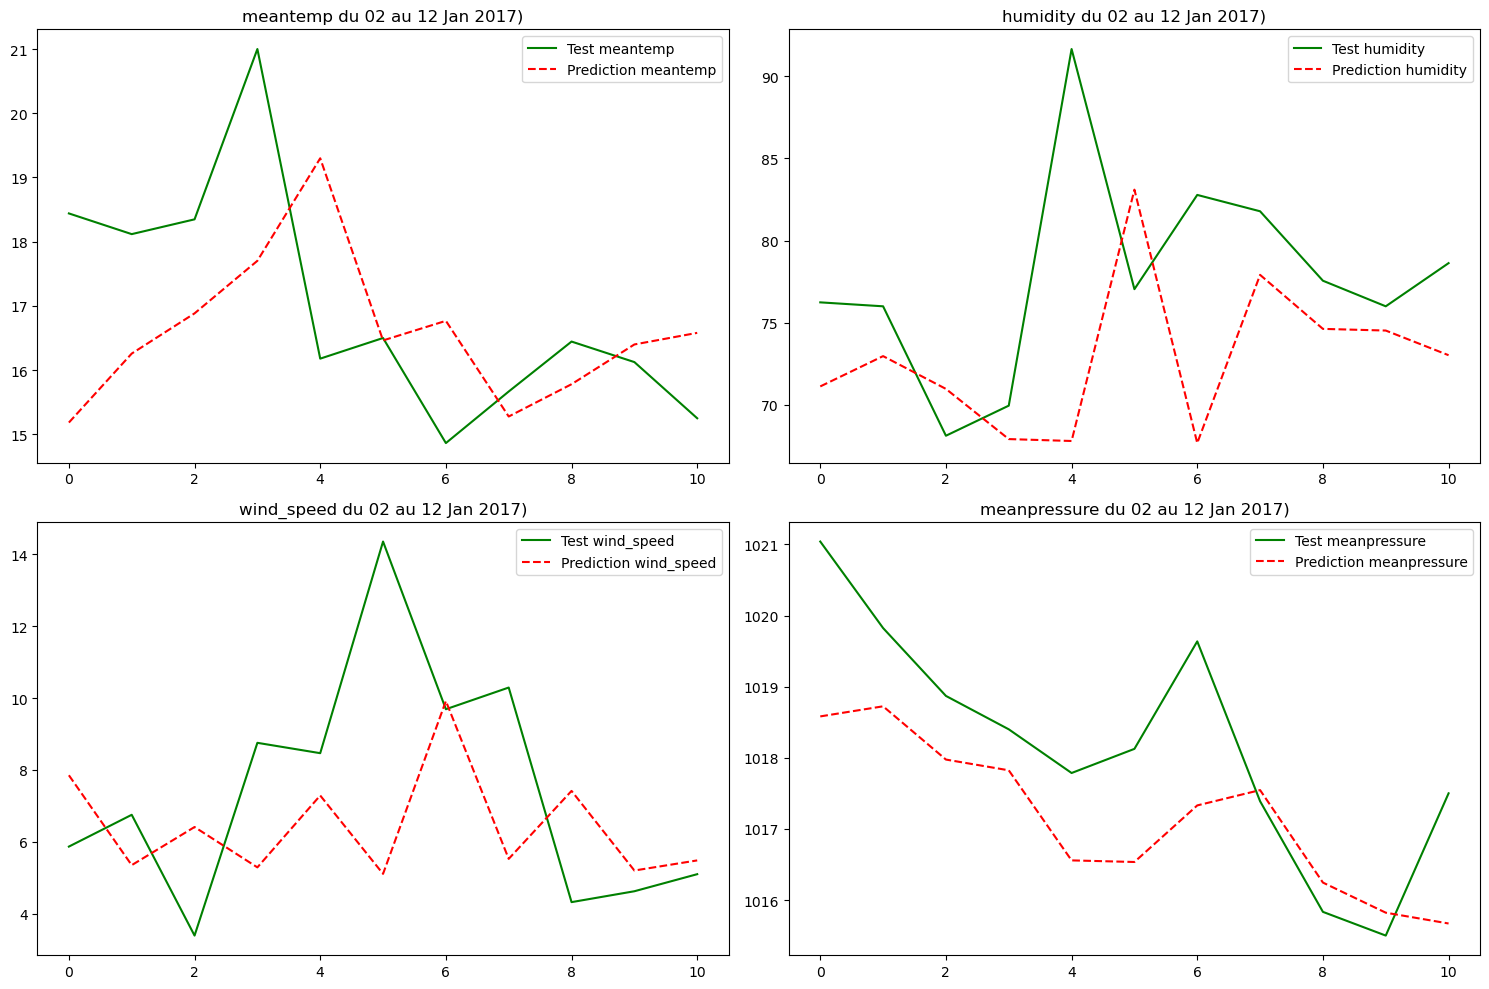

In [42]:
pre_processing(df_train, df_test)

<div style="font-size: 16px; letter-spacing: 1px; background-color:rgb(36, 159, 46); color: #FFFFFF; border-radius: 5px; padding: 5px 16px; font-weight: bold;">
    CONCLUSION
</div>

Les predictions sont assez concluant. On a pas les valeurs exacte, ce qui est assez complique a obtenir, mais le modele est correcte.

<div style="font-size: 24px; letter-spacing: 1px; background-color:rgb(100, 110, 210); color: #FFFFFF; border-radius: 5px; padding: 5px 16px; font-weight: bold;">
    9. Comparaison
</div>

In [49]:
model_gru3 = create_gru(64)

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_10 (GRU)                    │ (None, 20, 64)         │        13,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_11 (GRU)                    │ (None, 64)             │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,660 (151.02 KB)

 Trainable params: 38,660 (151.02 KB)

 Non-trainable params: 0 (0.00 B)

In [50]:
def pre_processing2(df_train, df_test):
    
    df_train = remove_aberant(df_train)
    df_test = remove_aberant(df_test)
    
    scaler_object = MinMaxScaler()
    scaler = scaler_object.fit(df_train)
    
    train_scaled = scaler.transform(df_train)
    test_scaled = scaler.transform(df_test)

    X_train, y_train = create_Xseq_and_y(train_scaled)
    X_test, y_test = create_Xseq_and_y(test_scaled)

    def fit_model(model):
        early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
        history = model.fit(X_train, y_train, epochs=100, validation_split=0.2, batch_size=16, shuffle=False, callbacks=[early_stop])
        return history

    fit_model(model_gru3)

    # Prédiction
    def prediction(model, X_test):
        predictions_scaled = model.predict(X_test)
        predictions = scaler.inverse_transform(predictions_scaled)
        return predictions

    prediction_gru3 = prediction(model_gru3, X_test)

    # Inverser la transformation des données pour obtenir les valeurs originales
    y_test_inv = scaler.inverse_transform(y_test)
    y_train_inv = scaler.inverse_transform(y_train)

    # Calculer les métriques
    metrics = {}
    columns = ["meantemp", "humidity", "wind_speed", "meanpressure"]

    for i, col in enumerate(columns):
        rmse = np.sqrt(mean_squared_error(y_test_inv[:, i], prediction_gru3[:, i]))
        mse = mean_squared_error(y_test_inv[:, i], prediction_gru3[:, i])
        mae = mean_absolute_error(y_test_inv[:, i], prediction_gru3[:, i])
        r2 = r2_score(y_test_inv[:, i], prediction_gru3[:, i])
        metrics[col] = {"RMSE": rmse, "MSE": mse, "MAE": mae, "R2": r2}

    # Affichage des métriques
    for col, values in metrics.items():
        print(f"\n{col}:")
        print(f"  RMSE: {values['RMSE']:.4f}")
        print(f"  MSE: {values['MSE']:.4f}")
        print(f"  MAE: {values['MAE']:.4f}")
        print(f"  R2: {values['R2']:.4f}")

    # Visualisation des résultats
    variables = ["meantemp", "humidity", "wind_speed", "meanpressure"]
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))  # 2 lignes, 2 colonnes

    for i, var in enumerate(variables):
        ax = axes[i // 2, i % 2]  # Position dans la grille
        ax.plot(y_train_inv[:, i], label=f"Train {var}", color="blue")
        ax.plot(range(len(y_train_inv), len(y_train_inv) + len(y_test_inv)), y_test_inv[:, i], label=f"Test {var}", color="green")
        ax.plot(range(len(y_train_inv), len(y_train_inv) + len(y_test_inv)), prediction_gru3[:, i], label=f"Prediction {var}", color="red", linestyle="dashed")
        
        ax.set_title(f"Comparaison pour {var}")
        ax.legend()
        
    plt.tight_layout()
    plt.show()


Epoch 1/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.1363 - val_loss: 0.0263
Epoch 2/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0282 - val_loss: 0.0192
Epoch 3/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0243 - val_loss: 0.0219
Epoch 4/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0238 - val_loss: 0.0179
Epoch 5/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0224 - val_loss: 0.0167
Epoch 6/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0208 - val_loss: 0.0159
Epoch 7/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0206 - val_loss: 0.0154
Epoch 8/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0199 - val_loss: 0.0154
Epoch 9/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0192 - val_loss: 0.0151
Epoch 10/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0191 - val_loss: 0.0158
Epoch 11/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0190 - val_loss: 0.0156
Epoch 12/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step

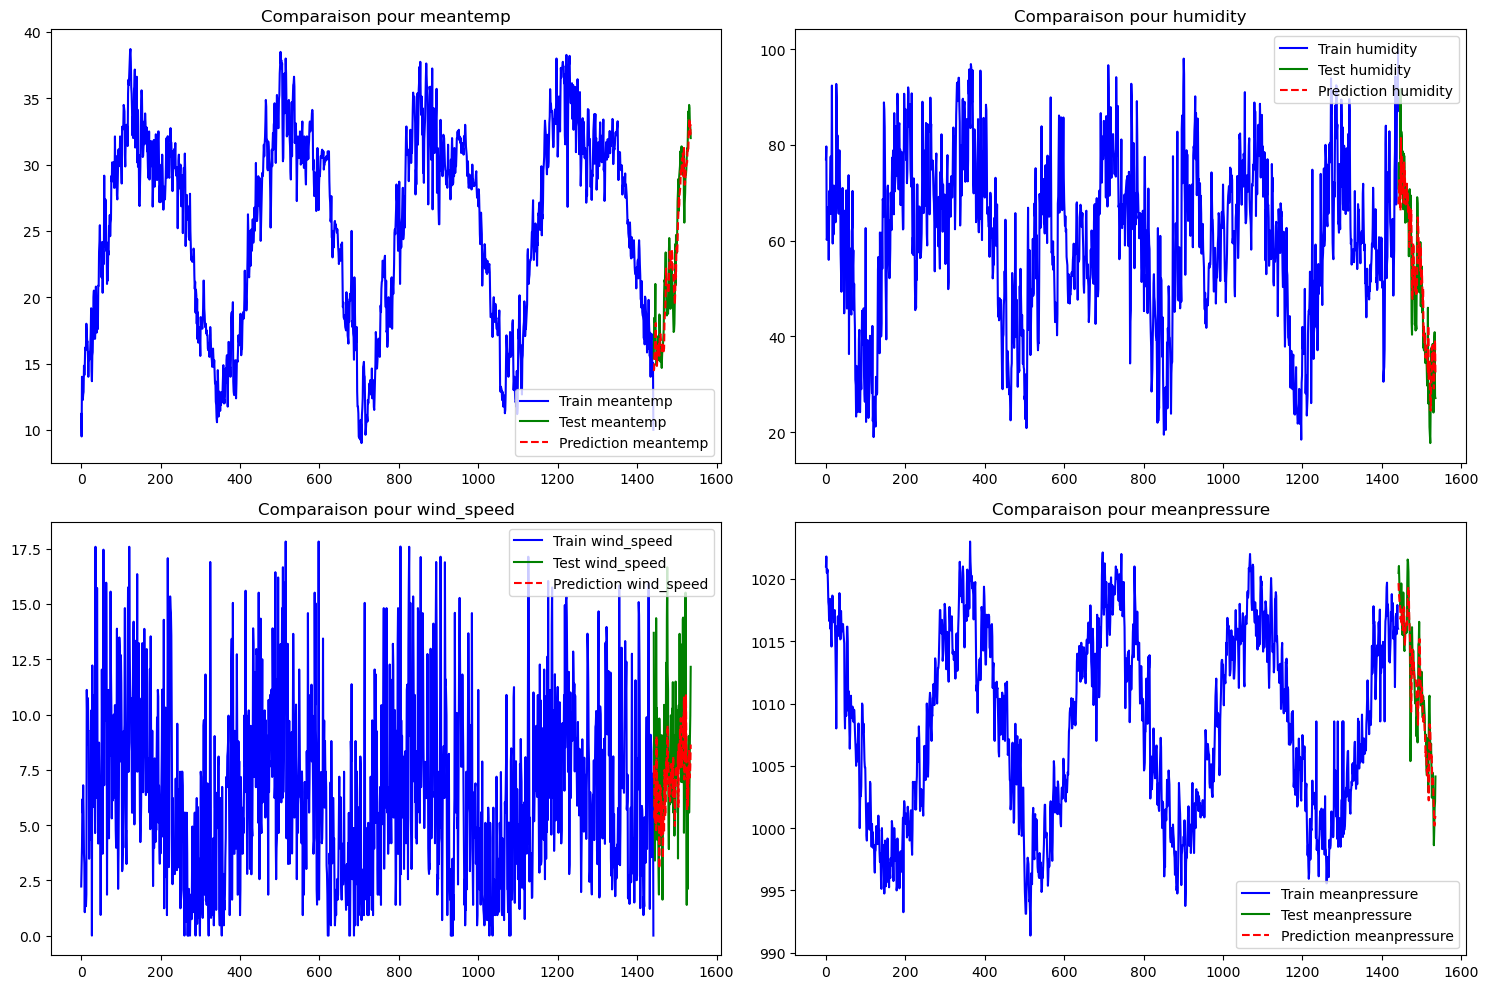

In [51]:
pre_processing2(df_train, df_test)